In [41]:
import os
import pickle
from collections import defaultdict
from itertools import product
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [42]:
def parse_results(directory, length_param_grid):
    
    files = [x for x in os.listdir(directory) if 'results' in x and '.txt.txt' not in x]

    results_dict = defaultdict(lambda:0)
    number_runs = defaultdict(lambda:0)
    all_params = []

    for file in files:
        param = int(file.split('_')[-2][1:])
        run_number = int(file.split('_')[-1].split('.')[0][1:])

        with open(directory+file, 'rb') as f:
            result = pickle.load(f)

        results_dict[param] += sum(result['presence_VR'])
        number_runs[param] += 10

        all_params.append((param, run_number))

    results_dict = dict(results_dict)
    
    # check that all runs are present
    missing = set(product(range(length_param_grid), range(100))).symmetric_difference(set(all_params))
    if len(missing) == 0:
        print('All runs have been parsed')
    else:
        print('Some runs are missing:', missing)
    
    percentage_takeover = dict(zip(list(results_dict.keys()), [results_dict[p]/number_runs[p] for p in list(results_dict.keys())]))
    confidence_intervals =  dict(zip(list(results_dict.keys()),[1.96*np.sqrt((percentage_takeover[p]*(1-percentage_takeover[p]))/1000) for p in list(results_dict.keys())]))
    
    return(percentage_takeover, confidence_intervals)

In [43]:
def get_index(df, desired_dict):

    subdf = df.copy()

    for keyval in desired_dict:
        if keyval in subdf.columns:
            subdf = subdf[subdf[keyval] == desired_dict[keyval]]
        
    # check that index unique
    if len(list(subdf.index)) != 1:
        print('Index not unique')
        
    return(subdf.index[0])

def get_paramgrid(file):
    with open(file, 'rb') as f:
        paramgrid = pickle.load(f)
    df = pd.DataFrame(paramgrid)  
    return(df)

In [44]:
basic_results, basic_ci = parse_results('bar_chart/fitness_defect/', 36)

All runs have been parsed


In [45]:
paramgrid_file = 'bar_chart/fitness_defect/paramgrid_appearance_barchart_fitnessdefect.txt'
df = get_paramgrid(paramgrid_file)

In [91]:
h = 0.3
q = 1
delta = 2
mu = 1e-6
season = 0.9
f = 0.8

combs_cl = [(100,1000),(100,10000),(500,1000),(500,10000)]
mu_range = sorted(list(set(df['mu'])))

In [92]:
mu_range

[1e-07, 1e-06]

In [93]:
basic_results

{0: 0.003,
 10: 0.011,
 11: 0.081,
 12: 0.0,
 13: 0.003,
 14: 0.0,
 15: 0.012,
 16: 0.001,
 17: 0.01,
 18: 0.001,
 19: 0.004,
 1: 0.007,
 20: 0.003,
 21: 0.019,
 22: 0.003,
 23: 0.034,
 24: 0.0,
 25: 0.002,
 26: 0.001,
 27: 0.002,
 28: 0.001,
 29: 0.014,
 2: 0.005,
 30: 0.0,
 31: 0.002,
 32: 0.0,
 33: 0.006,
 34: 0.002,
 35: 0.02,
 3: 0.036,
 4: 0.002,
 5: 0.053,
 6: 0.005,
 7: 0.019,
 8: 0.004,
 9: 0.051}

In [94]:
all_bar_results = [] 
all_bar_ci = [] 

for L, c in combs_cl:
    bar_results = defaultdict(list)
    bar_ci = defaultdict(list)
    
    desired_dict = {'delta':delta, 'mu':mu, 'q':q, 'c':c, 'i_threshold':L, 'hesitancy':h, 'season':season}
    
    for sim in [0.8,1]:
        desired_dict['delta'] = sim
        bar_results[sim] = basic_results[get_index(df, desired_dict)]
        bar_ci[sim] = basic_ci[get_index(df, desired_dict)]
            
    all_bar_results.append(list(bar_results.values()))
    all_bar_ci.append(list(bar_ci.values()))

In [95]:
all_labels = ['Vaccine resistant mutant less infectious', 'Vaccine resistant mutant equally infectious']

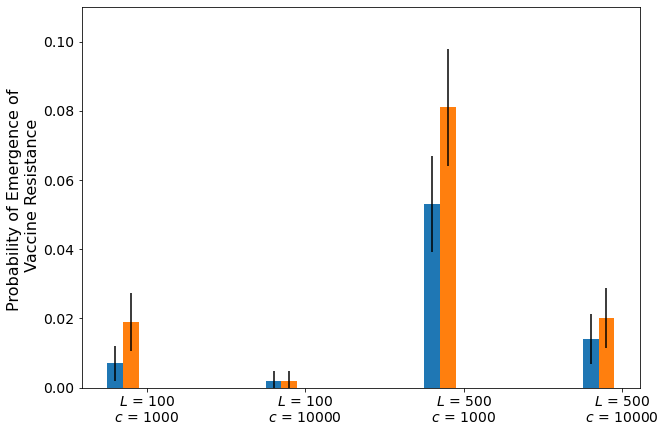

In [98]:
x = np.arange(0,4.,1)  # the label locations
width = 0.1  # the width of the bars
pos = np.arange(0,3.,0.5)

fig, ax = plt.subplots(figsize = (10,7))

for n in range(2):
    bars = ax.bar(x + pos[n]*width*2, np.array(all_bar_results)[:,n], width, yerr = np.array(all_bar_ci)[:,n], label=all_labels[n])
    

ax.set_ylabel('Probability of Emergence of \n Vaccine Resistance', fontsize = 16)
ax.set_xticks(x+0.2)
ax.set_xticklabels(['$L$ = ' + str(x[0]) + '\n$c$ = ' + str(x[1])  for x in combs_cl], fontsize = 14)
#ax.legend(fontsize = 14, bbox_to_anchor = (2.,1.1))
ax.set_ylim(0.,0.11)
ax.tick_params(labelsize = '14')

plt.savefig('less_infectious_barchart_mu6.jpg', dpi = 400, bbox_inches = 'tight')